# Manifold's consistency


* **Authors**:

  * Author: steevelaquitaine@epfl.ch; laquitainesteeve@gmail.com.
  * Adapted from notebooks by Steffen Schneider, Jin H Lee, Mackenzie Mathis.  
  * Duration: 3h

* **Learning outcomes**:

  * know how to use CEBRA to measure the consistency of manifolds across subjects.

* **Readings**:

  * Schneider, S., Lee, J. H., & Mathis, M. W. (2023). Learnable latent embeddings for joint behavioural and neural analysis. Nature, 617(7960), 360-368. see [Figure 1](https://cebra.ai/docs/cebra-figures/figures/Figure1.html).

* **Python prerequisites**:

  * installing and importing `libraries`
  * plotting with `matplotlib` library

## (5m) Setup

1. Install `Cebra` with Python's pip software package manager (requires internet connection).
2. Import `software packages` (requires internet connection)

In [ ]:
import time
import locale
t0 = time.time()
locale.getpreferredencoding = lambda: "UTF-8"
!pip install ipython-autotime # time track colab notebook cells
!pip install --pre 'cebra[datasets,demos]'
%load_ext autotime

In [ ]:
# import software packages
import sys
import numpy as np
import matplotlib.pyplot as plt
import cebra.datasets
from cebra import CEBRA

time: 11.4 s (started: 2024-03-14 17:28:06 +00:00)


## (10s) Loading the dataset

- Four rats
- The data will be automatically downloaded into a `/data` folder.

In [ ]:
hippocampus_pos = {}
hippocampus_pos["achilles"] = cebra.datasets.init('rat-hippocampus-single-achilles')
hippocampus_pos["buddy"] = cebra.datasets.init('rat-hippocampus-single-buddy')
hippocampus_pos["cicero"] = cebra.datasets.init('rat-hippocampus-single-cicero')
hippocampus_pos["gatsby"] = cebra.datasets.init('rat-hippocampus-single-gatsby')

100%|██████████| 10.0M/10.0M [00:00<00:00, 13.1MB/s]


Download complete. Dataset saved in 'data/rat_hippocampus/achilles.jl'


100%|██████████| 2.68M/2.68M [00:00<00:00, 4.38MB/s]


Download complete. Dataset saved in 'data/rat_hippocampus/buddy.jl'


100%|██████████| 22.0M/22.0M [00:01<00:00, 16.5MB/s]


Download complete. Dataset saved in 'data/rat_hippocampus/cicero.jl'


100%|██████████| 9.40M/9.40M [00:00<00:00, 9.49MB/s]

Download complete. Dataset saved in 'data/rat_hippocampus/gatsby.jl'
time: 8.42 s (started: 2024-03-14 17:28:17 +00:00)


## (1s) Describe the data

### (1s) Plot

* plot one rat

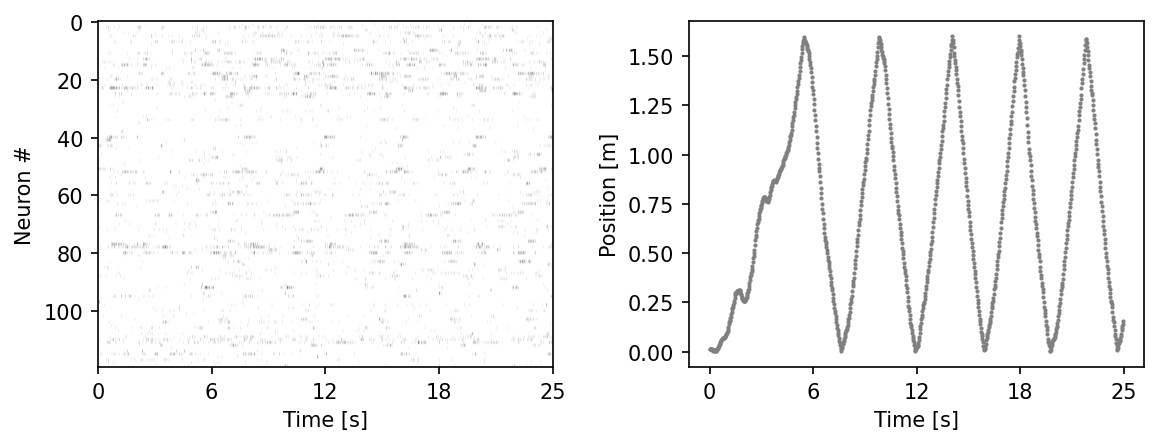

time: 1.68 s (started: 2024-03-14 17:28:26 +00:00)


In [ ]:
# plot
fig = plt.figure(figsize=(9,3), dpi=150)
plt.subplots_adjust(wspace = 0.3)
ax = plt.subplot(121)
ax.imshow(hippocampus_pos["achilles"].neural.numpy()[:1000].T, aspect = 'auto', cmap = 'gray_r')
plt.ylabel('Neuron #')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype = int))

ax2 = plt.subplot(122)
ax2.scatter(np.arange(1000), hippocampus_pos["achilles"].continuous_index[:1000,0], c = 'gray', s=1)
plt.ylabel('Position [m]')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype = int))
plt.show()

## (45s) Parametrize/Train the models

### (27m) Time model

- Train a model that uses time without the behavior information.
- We can use CEBRA -Time mode by setting conditional = 'time'
- We train the model with neural data only.

- For a quick CPU run-time demo, you can drop `max_iterations` to 100-500; otherwise set to 5000.

In [ ]:
max_iterations = 5000 # 15000 #default is 5000.

for mouse in list(hippocampus_pos.keys()):

    cebra_time3_model = CEBRA(model_architecture='offset10-model',
                            batch_size=512,
                            learning_rate=3e-4,
                            temperature=1.12,
                            output_dimension=3,
                            max_iterations=max_iterations,
                            distance='cosine',
                            conditional='time',
                            device='cuda_if_available',
                            verbose=True,
                            time_offsets=10)

    cebra_time3_model.fit(hippocampus_pos[mouse].neural)
    cebra_time3_model.save(f"cebra_time3_model_{mouse}.pt")


pos: -0.8507 neg:  6.3704 total:  5.5196 temperature:  1.1200: 100%|██████████| 5000/5000 [08:08<00:00, 10.25it/s]
pos: -0.7532 neg:  6.3839 total:  5.6307 temperature:  1.1200: 100%|██████████| 5000/5000 [06:02<00:00, 13.81it/s]
pos: -0.5208 neg:  6.3847 total:  5.8640 temperature:  1.1200: 100%|██████████| 5000/5000 [06:17<00:00, 13.24it/s]
pos: -0.7633 neg:  6.3796 total:  5.6163 temperature:  1.1200: 100%|██████████| 5000/5000 [06:38<00:00, 12.54it/s]

time: 27min 13s (started: 2024-03-14 17:28:27 +00:00)


### (3m) Behavior model

- We will train a model with 3D output that uses positional information (position + direction).
- Setting conditional = 'time_delta' means we will use CEBRA-Behavior mode and use auxiliary behavior variable for the model training.
- We train the model with neural data and the behavior variable including position and direction.

In [ ]:
for mouse in list(hippocampus_pos.keys()):

    cebra_posdir3_model = CEBRA(model_architecture='offset10-model',
                            batch_size=512,
                            learning_rate=3e-4,
                            temperature=1,
                            output_dimension=3,
                            max_iterations=max_iterations,
                            distance='cosine',
                            conditional='time_delta',
                            device='cuda_if_available',
                            verbose=True,
                            time_offsets=10)

    cebra_posdir3_model.fit(hippocampus_pos[mouse].neural, hippocampus_pos[mouse].continuous_index.numpy())
    cebra_posdir3_model.save(f"cebra_posdir3_model_{mouse}.pt")

pos: -0.8980 neg:  6.4180 total:  5.5200 temperature:  1.0000: 100%|██████████| 5000/5000 [19:19<00:00,  4.31it/s]
pos: -0.7536 neg:  6.4366 total:  5.6830 temperature:  1.0000: 100%|██████████| 5000/5000 [12:32<00:00,  6.64it/s]
pos: -0.5458 neg:  6.4494 total:  5.9035 temperature:  1.0000: 100%|██████████| 5000/5000 [1:27:47<00:00,  1.05s/it]
pos: -0.8230 neg:  6.4827 total:  5.6598 temperature:  1.0000: 100%|██████████| 5000/5000 [34:01<00:00,  2.45it/s]

time: 2h 33min 41s (started: 2024-03-14 17:55:41 +00:00)


## (1s) Get the manifolds

In [ ]:
time3_models, time3_embeddings = {}, {}
posdir3_models, posdir3_embeddings = {}, {}
left, right = {}, {}

for mouse in list(hippocampus_pos.keys()):

    # time constrative models
    time3_models[mouse] = cebra.CEBRA.load(f"cebra_time3_model_{mouse}.pt")
    time3_embeddings[mouse] = time3_models[mouse].transform(hippocampus_pos[mouse].neural)

    # behavioral contrastive models
    posdir3_models[mouse] = cebra.CEBRA.load(f"cebra_posdir3_model_{mouse}.pt")
    posdir3_embeddings[mouse] = posdir3_models[mouse].transform(hippocampus_pos[mouse].neural)

    # left and right labels for the embedding
    right[mouse] = hippocampus_pos[mouse].continuous_index[:,1] == 1
    left[mouse] = hippocampus_pos[mouse].continuous_index[:,2] == 1

time: 810 ms (started: 2024-03-14 20:29:22 +00:00)


## (1s) Plot

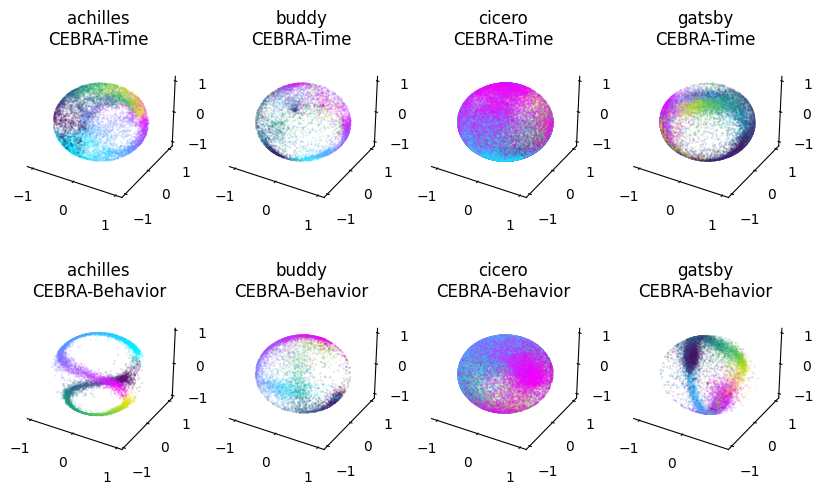

time: 4.98 s (started: 2024-03-14 20:29:23 +00:00)


In [ ]:
%matplotlib inline

fig = plt.figure(figsize=(10,6))

ax1 = plt.subplot(241, projection='3d')
ax2 = plt.subplot(242, projection='3d')
ax3 = plt.subplot(243, projection='3d')
ax4 = plt.subplot(244, projection='3d')
axs_up = [ax1, ax2, ax3, ax4]

ax1 = plt.subplot(245, projection='3d')
ax2 = plt.subplot(246, projection='3d')
ax3 = plt.subplot(247, projection='3d')
ax4 = plt.subplot(248, projection='3d')
axs_down = [ax1, ax2, ax3, ax4]

for ax, mouse in  zip(axs_up, list(time3_embeddings.keys())):
    for dir, cmap in zip([right[mouse], left[mouse]], ["cool", "viridis"]):
        ax=cebra.plot_embedding(ax=ax, embedding=time3_embeddings[mouse][dir,:], embedding_labels=hippocampus_pos[mouse].continuous_index[dir,0], title=f"{mouse}\nCEBRA-Time", cmap=cmap)

for ax, mouse in  zip(axs_down, list(posdir3_embeddings.keys())):
    for dir, cmap in zip([right[mouse], left[mouse]], ["cool", "viridis"]):
        ax=cebra.plot_embedding(ax=ax, embedding=posdir3_embeddings[mouse][dir,:], embedding_labels=hippocampus_pos[mouse].continuous_index[dir,0], title=f"{mouse}\nCEBRA-Behavior", cmap=cmap)


plt.show()

## Compute the consistency maps

Correlation matrices depict the $R^2$ after fitting a linear model between behavior-aligned embeddings of two animals, one as the target one as the source (mean, n=10 runs). Parameters were picked by optimizing average run consistency across rats.

In [ ]:
# labels to align the subjects is the position of the mouse in the arena
labels = [hippocampus_pos[mouse].continuous_index[:, 0]
          for mouse in list(hippocampus_pos.keys())]

# CEBRA-Time consistencies
time_scores, time_pairs, time_subjects = cebra.sklearn.metrics.consistency_score(embeddings=list(time3_embeddings.values()),
                                                                                 labels=labels,
                                                                                 dataset_ids=list(
                                                                                     time3_embeddings.keys()),
                                                                                 between="datasets")

# CEBRA-Behavior consistencies
posdir_scores, posdir_pairs, posdir_subjects = cebra.sklearn.metrics.consistency_score(embeddings=list(posdir3_embeddings.values()),
                                                                                       labels=labels,
                                                                                       dataset_ids=list(
                                                                                           posdir3_embeddings.keys()),
                                                                                       between="datasets")


time: 375 ms (started: 2024-03-14 20:29:28 +00:00)


### Plot

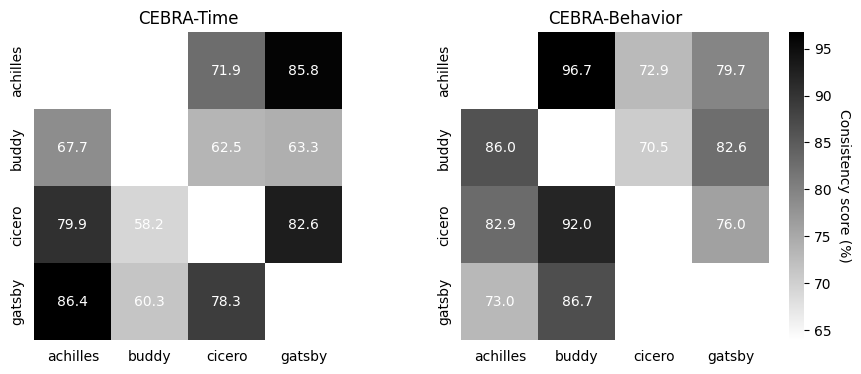

time: 570 ms (started: 2024-03-14 20:29:29 +00:00)


In [ ]:
%matplotlib inline

# Display consistency maps
fig = plt.figure(figsize=(11, 4))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1 = cebra.plot_consistency(time_scores, pairs=time_pairs, datasets=time_subjects,
                             ax=ax1, title="CEBRA-Time", colorbar_label=None)
ax2 = cebra.plot_consistency(
    posdir_scores, pairs=posdir_pairs, datasets=posdir_subjects, ax=ax2, title="CEBRA-Behavior")


In [ ]:
print("The notebook execution took:", np.round(time.time() - t0),1)

The notebook execution took: 11028.0 1
time: 8.19 ms (started: 2024-03-14 20:29:29 +00:00)
